In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
import sklearn.neighbors
from lib.scikitComponents import *
import itertools
import collections
from lib.scikitComponents import pipelines
import scipy.stats

## Data preprocessing

In [3]:
# Load in the previously created corpus and dictionary of scraped sites
Datas = collections.namedtuple('Datas', ['dictionary', 'corpus', 'meta_corpus', 'dmoz_data'])
unstemmed = Datas(*jsoncorpus.load_or_create('docs/sites.jl'))
stemmed = Datas(*jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_"))

Done.
Done.


In [4]:
def merge_corpus(a, b):
    a = dict(a)
    b = dict(b)
    for k in b:
        old = a.get(k, 0)
        a[k] = old + b[k]
    return [(k, a[k]) for k in a]




def preprocess(data):
    merged_corpus = [merge_corpus(a, b) for a, b in zip(data.corpus, data.meta_corpus)]
    # Set up array of input data
    X = zip(list(data.corpus), list(data.meta_corpus), merged_corpus)
    # Link topics to URLs
    meta = list(zip(data.dmoz_data['urls'], data.dmoz_data['dmoz_categories']))
    # Encode class labels
    classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(data.dmoz_data['dmoz_categories'], merged_corpus)
    return (X, meta, classes, top_categories, dmoz_encoder)

X, meta, classes, top_categories, dmoz_encoder = preprocess(stemmed)

In [19]:
def newline_name(name):
    if len(name.split()) == 1:
        return name
    return "{}\n{}".format(name.split()[-1], name.split()[0])
    #return "\n".join(reversed(name.split()))

def makeboxplot(scores, clfs, ylabel='Weighted F1 cross-validation scores', figsize=None, inds=None, maxp=None, showtext=False):
    inds = inds or range(len(clfs))
    sortinds = np.argsort(np.mean(np.array(scores).T, axis=0))
    scores_sorted = np.array(scores)[sortinds, :].T[:, inds]
    labels_sorted = np.array([clf.name for clf in clfs])[sortinds][inds]
    
    
    if figsize:
        plt.figure(figsize=figsize)
    
    box_params = dict(showmeans=True,widths=0.8, flierprops=dict(marker='o'), patch_artist=True)
    
    maxp = maxp or max(inds)+1
    box = plt.boxplot(scores_sorted, labels = [newline_name(l) for l in labels_sorted], whis=100, positions = np.array(inds)+1, **box_params)
    plt.ylabel(ylabel)
    plt.xlim((0.5, maxp+0.5))
    if showtext:
        for i, s in enumerate(scores_sorted.T):
            text = "{:.3} = {}".format(np.mean(s), labels_sorted[i])
            tx = maxp+0.55
            ty = np.mean(s)
    #        if inds[i] == 1: ty -= 0.01
    #        if inds[i] == 7: ty += 0.01
            plt.text(tx, ty, text, va='center', fontsize=12)
            props = dict(color='gray', shrink=0.05, frac=0.12/float
                         (len(clfs) - i), width=0.5, headwidth=3)

def print_pvalue(names, scores):
    for a, b in itertools.combinations(zip(names, scores), 2):
        aname, ascore = a
        bname, bscore = b
        pvalue = scipy.stats.ttest_ind(ascore, bscore, equal_var=False)[1]
        print "[{}] vs [{}]: p-value = {}%".format(aname, bname, pvalue)

In [6]:
verbosity = 3

## Boxplots for different representation combinations

In [7]:
dictionary = stemmed.dictionary


## Stemming comparison

In [60]:
X_s, meta_s, classes_s, top_categories_s, dmoz_encoder_s = preprocess(stemmed)
X_u, meta_u, classes_u, top_categories_u, dmoz_encoder_u = preprocess(unstemmed)

In [61]:
clf_s = pipelines.make_classifier(stemmed.dictionary, corp_type='both', feature='tfidf', classifier = 'svc')
clf_u = pipelines.make_classifier(unstemmed.dictionary, corp_type='both', feature='tfidf', classifier = 'svc')
score_s = sklearn.cross_validation.cross_val_score(clf_s, X_s, classes_s, cv=5, verbose=verbosity, scoring='f1_weighted')
score_u = sklearn.cross_validation.cross_val_score(clf_u, X_u, classes_u, cv=5, verbose=verbosity, scoring='f1_weighted')

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.549636 -   1.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.552951 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.583965 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.553412 -   1.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.492715 -   1.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.0s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.496961 -   1.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.524849 -   1.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.559301 -   1.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.545855 -   2.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.474694 -   1.7s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished


Stemmed
Accuracy: 0.547 (+/- 0.06)
Dictionary has 13021 words

Unstemmed
Accuracy: 0.520 (+/- 0.06)
Dictionary has 17947 words

[Stemming] vs [Not]: p-value = 0.25701187775%


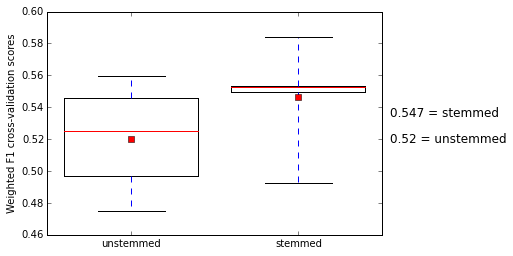

In [87]:
print "Stemmed"
analysis.print_score_accuracy(score_s)
print "Dictionary has {} words".format(len(stemmed.dictionary))
print

print "Unstemmed"
analysis.print_score_accuracy(score_u)
print "Dictionary has {} words".format(len(unstemmed.dictionary))
print

clf_s.name = "stemmed"
clf_u.name = "unstemmed"
makeboxplot([score_s, score_u], [clf_s, clf_u])
print_pvalue(["Stemming", "Not"], [score_s, score_u])
plt.savefig('box_stemming.pdf', bbox_inches='tight')

In [71]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=False)

In [72]:
# k = 3
# makeboxplot(scores[-k:], clfs[-k:])
# print_pvalue([c.name for c in clfs[-k:]], scores[-k:])
# plt.savefig('box_meta_or_body.pdf', bbox_inches='tight')

NameError: global name 'positions' is not defined

In [11]:
cclfs = np.array([
    pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='trees'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='trees'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='trees'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='nb'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='nb'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='nb'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='sgd'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='sgd'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='sgd')
])

In [12]:
cscores = [sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5, verbose=verbosity, scoring='f1_weighted') 
 for clf in cclfs]

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.549636 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.552951 -   2.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.583965 -   1.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.553412 -   1.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.492715 -   1.7s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.0s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.267884 -  11.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.292067 -  13.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.337246 -  12.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.357162 -  12.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.321847 -  11.3s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.473392 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.490220 -   0.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.497766 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.451818 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.463133 -   0.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.446680 -  10.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.426409 -  10.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.494589 -  13.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.433139 -  12.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.394221 -  13.5s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.336821 -  12.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.335712 -  11.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.389850 -  11.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.394031 -  12.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.357670 -  11.7s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.9s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.389106 -   6.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.389572 -   6.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.438993 -   6.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.405994 -   6.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.384531 -   6.7s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.306950 -   1.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.320029 -   1.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.360733 -   1.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.337536 -   1.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.301682 -   1.4s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.109967 -  11.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.130131 -  12.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.121758 -  13.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.141519 -  14.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.130741 -  12.2s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.445791 -   0.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.441340 -   0.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.515810 -   0.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.470214 -   0.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.496459 -   0.3s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.542488 -   6.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.559008 -   6.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.550657 -   6.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.523781 -   6.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.476124 -   6.8s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.4s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.315195 -  13.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.295011 -  12.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.334144 -  11.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.276378 -  12.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.288350 -  12.3s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.390022 -   5.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.421862 -   5.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.438673 -   5.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.405374 -   6.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.442654 -   7.3s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.8s finished


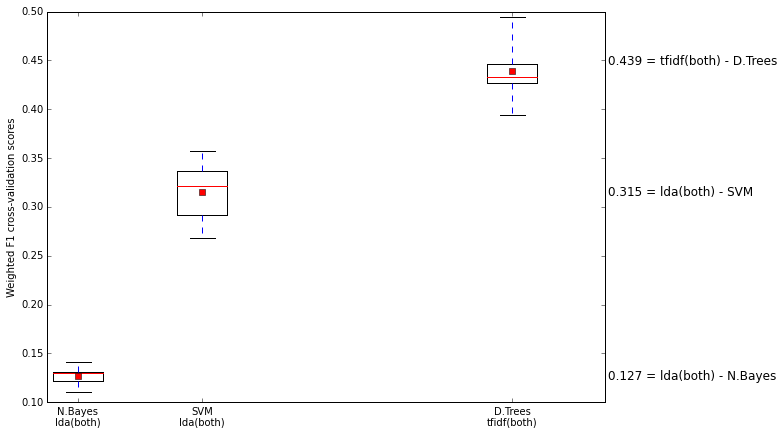

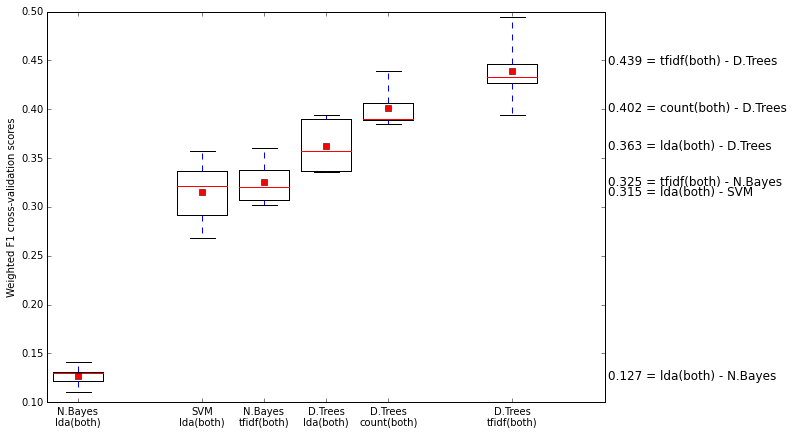

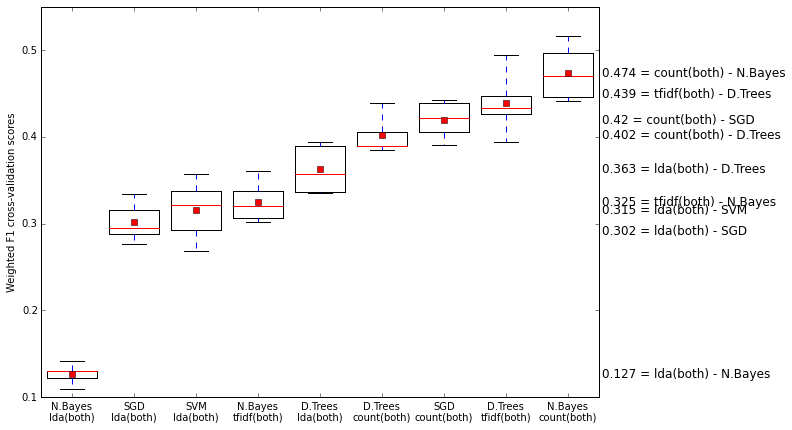

In [13]:


inds = [0, 2, 7]
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (10, 7), inds = inds, maxp=9)
plt.savefig('box_full_1.pdf', bbox_inches='tight')
inds = inds + [3, 4, 5]
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (10, 7), inds = inds, maxp=9)
plt.savefig('box_full_2.pdf', bbox_inches='tight')
inds = inds + [1, 6, 8]
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (10, 7), inds = inds, maxp=9)
plt.savefig('box_full_3.pdf', bbox_inches='tight')



In [ ]:
bclfs = np.array([
    pipelines.make_classifier(dictionary, corp_type='meta', feature='tfidf', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='body', feature='tfidf', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='svc')
])
bscores = [sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5, verbose=verbosity, scoring='f1_weighted') 
 for clf in bclfs]



[meta] vs [body]: p-value = 0.0117970386658%
[meta] vs [both]: p-value = 0.002727105622%
[body] vs [both]: p-value = 0.18826281318%


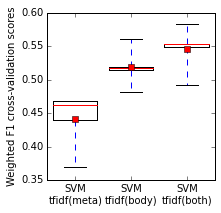

In [56]:
makeboxplot(np.array(bscores), np.array(bclfs), figsize = (3, 3))
print_pvalue(['meta', 'body', 'both'], np.array(bscores))

In [65]:
print np.mean(bscores, axis=1)
print np.std(bscores, axis=1) * 2.0

[ 0.44177254  0.5184921   0.54653564]
[ 0.07548238  0.05035255  0.05930034]


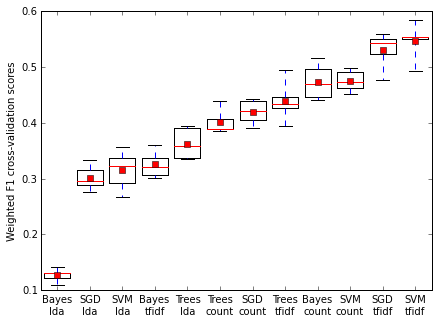

In [45]:
import re
for c in cclfs:
    c.name = re.sub(r'\(.*\)', '', c.name)
    c.name = re.sub(r'D\.', '', c.name)
    c.name = re.sub(r'N\.', '', c.name)
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (7, 5))
plt.savefig('box_final.pdf', bbox_inches='tight')

In [585]:
words = []
for c in range(14):
    weights = cclfs[4].steps[1][1].coef_[c]
    inds = np.argsort(weights)[::-1]
    best = [dictionary[i] for i in inds][:9]
    words.append(best)
    print "\\item \\textbf{{{}}}: {}".format(dmoz_encoder.inverse_transform(c), ", ".join(best))
#np.array(words)

\item \textbf{arts}: art, artist, award, design, costum, font, film, tattoo, literari
\item \textbf{business}: busi, compani, product, investor, drill, sustain, financi, industri, nanni
\item \textbf{computers}: comput, file, usenet, softwar, bb, algorithm, robot, window, emul
\item \textbf{games}: game, dice, puzzl, rpg, wargam, miniatur, stack, diplomaci, parti
\item \textbf{health}: health, pharmaci, addict, diseas, drug, osha, age, veterinari, care
\item \textbf{home}: garden, diy, apart, toy, consum, clean, move, kitchen, plant
\item \textbf{kids and teens}: kid, parent, teacher, clipart, fun, homeschool, children, disney, manor
\item \textbf{news}: newspap, netanyahu, weather, obama, news, radio, iran, polit, forecast
\item \textbf{recreation}: hike, lock, climb, bird, cave, travel, camp, pet, whip
\item \textbf{reference}: librari, knot, dictionari, isbn, thesauru, biographi, word, encyclopedia, answer
\item \textbf{regional}: popul, countri, cia, island, nat, territori, geograp

In [548]:
dictionary[4]

u'yellow'